In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Import data acquisition and prep
from acquire import get_data
from prep import prep_data

#import our scripts that assist data science workflow
import split_scale
import features
# import evaluate

In [21]:
# This cell acquires and prepares the data
# Get the raw data from .csv or MySQL query
raw = get_data()

# Remove nulls
df = prep_data(raw)

Reading data from ./zillow.csv


In [22]:
train, test = split_scale.split_my_data(df)

In [23]:
columns_to_drop = ["taxvalue"]

In [24]:
scaler, train_scaled, test_scaled = split_scale.standard_scaler(train.drop(columns=columns_to_drop),test.drop(columns=columns_to_drop))

In [25]:
print(train_scaled)
print(test_scaled)

       bathrooms  bedrooms      sqft
4432    0.156363  0.782807  0.180526
6689    0.156363 -0.187296 -0.171848
14953  -0.341933 -1.157398 -0.406079
14879   0.654659  0.782807  0.335652
7771   -0.341933 -1.157398 -0.212941
...          ...       ...       ...
13565   0.654659 -0.187296 -0.154384
7863   -0.341933 -0.187296 -0.583807
15512  -0.341933 -0.187296 -0.124591
17876  -0.341933 -0.187296 -0.712223
15862  -1.338524 -1.157398 -1.205341

[14570 rows x 3 columns]
       bathrooms  bedrooms      sqft
3712    0.156363  0.782807 -0.047541
12581  -1.338524 -1.157398 -0.353685
16966  -1.338524 -1.157398 -1.011176
13563  -0.341933  0.782807 -0.173903
11764   0.654659 -0.187296  0.835962
...          ...       ...       ...
4162    1.651250 -0.187296  6.382511
14293   0.654659 -0.187296  0.888355
17782   1.651250  0.782807  2.540300
17930  -1.338524 -1.157398 -1.019395
970    -0.341933 -0.187296 -0.018776

[3643 rows x 3 columns]


In [26]:
X_train = train_scaled
y_train = train[["taxvalue"]]
X_test = test_scaled
y_test = test[["taxvalue"]]

In [27]:
# Select the optimal number of features:
optimal_number = features.optimal_number_of_features(X_train, y_train)
optimal_number = optimal_number[0]
print("The optimal number of features is", optimal_number)

The optimal number of features is 3


In [28]:
features.optimal_features(X_train, X_test, y_train, optimal_number)

(Index(['bathrooms', 'bedrooms', 'sqft'], dtype='object'),
        bathrooms  bedrooms      sqft
 0       0.156363  0.782807  0.180526
 1       0.156363 -0.187296 -0.171848
 2      -0.341933 -1.157398 -0.406079
 3       0.654659  0.782807  0.335652
 4      -0.341933 -1.157398 -0.212941
 ...          ...       ...       ...
 14565   0.654659 -0.187296 -0.154384
 14566  -0.341933 -0.187296 -0.583807
 14567  -0.341933 -0.187296 -0.124591
 14568  -0.341933 -0.187296 -0.712223
 14569  -1.338524 -1.157398 -1.205341
 
 [14570 rows x 3 columns],
       bathrooms  bedrooms      sqft
 0      0.156363  0.782807 -0.047541
 1     -1.338524 -1.157398 -0.353685
 2     -1.338524 -1.157398 -1.011176
 3     -0.341933  0.782807 -0.173903
 4      0.654659 -0.187296  0.835962
 ...         ...       ...       ...
 3638   1.651250 -0.187296  6.382511
 3639   0.654659 -0.187296  0.888355
 3640   1.651250  0.782807  2.540300
 3641  -1.338524 -1.157398 -1.019395
 3642  -0.341933 -0.187296 -0.018776
 
 [3643 row

In [29]:
# First Model
model = LinearRegression()
model.fit(X_train, y_train)

model.predict(X_train)
predictions = model.predict(X_train)
predictions = predictions.flatten()

In [35]:
compare_model = pd.DataFrame()

compare_model["actual"] = y_train.taxvalue
compare_model["predicted"] = predictions
compare_model["baseline"] = y_train.mean()[0]

In [36]:
compare_model.head()

,actual,predicted,baseline
4432,585076.0,492481.535711,518416.357172
6689,498687.0,475954.642133,518416.357172
14953,348230.0,487874.272191,518416.357172
14879,801085.0,588275.484738,518416.357172
7771,60425.0,575683.328057,518416.357172


In [37]:
def modeling_function(X_train,X_test,y_train,y_test):
    predictions_train=pd.DataFrame({'actual':y_train.taxvalue}).reset_index(drop=True)
    predictions_test=pd.DataFrame({'actual':y_test.taxvalue}).reset_index(drop=True)

    #model 1
    lm1=LinearRegression()
    lm1.fit(X_train,y_train)
    lm1_predictions=lm1.predict(X_train)
    predictions_train['lm1']=lm1_predictions

    #model 2
    lm2=LinearRegression()
    lm2.fit(X_test,y_test)
    lm2_predictions=lm2.predict(X_test)
    predictions_test['lm2']=lm2_predictions
    
    return predictions_train,predictions_test

In [38]:
model_train, model_test=modeling_function(X_train, X_test, y_train, y_test)

In [44]:
def plot_residuals(x, y):
    '''
    Plots the residuals of a model that uses x to predict y. Note that we don't
    need to make any predictions ourselves here, seaborn will create the model
    and predictions for us under the hood with the `residplot` function.
    '''
    return sns.residplot(x, y)

In [46]:
test_scaled.head()

,bathrooms,bedrooms,sqft
3712,0.156363,0.782807,-0.047541
12581,-1.338524,-1.157398,-0.353685
16966,-1.338524,-1.157398,-1.011176
13563,-0.341933,0.782807,-0.173903
11764,0.654659,-0.187296,0.835962


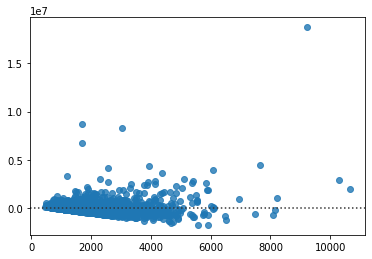

In [50]:
x = test[['sqft']]
y = test[['taxvalue']]
plot_residuals(x,y)

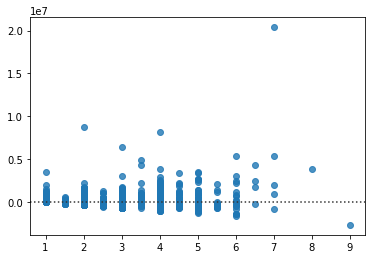

In [51]:
x = test[['bathrooms']]
y = test[['taxvalue']]
plot_residuals(x,y)

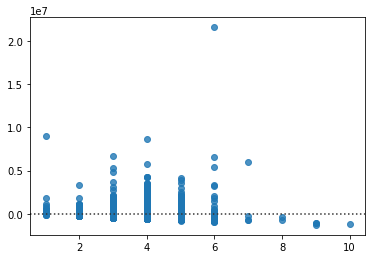

In [52]:
x = test[['bedrooms']]
y = test[['taxvalue']]
plot_residuals(x,y)